In [88]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
#from numpy.linalg import inv, det
import george
from george import kernels

from redTools import *
from Kcorrect import *

from matplotlib import rcParams
rcParams["font.size"] = 14
#rcParams["font.family"] = "sans-serif"
#rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"

################################################################# 

In [107]:
band2 = 'w2'


band1 = 'g'
_, Input, T = getBand('ESN_HI_catal.csv', band1=band1 , band2=band2)
pc0     = Input[2]
inc     = Input[3]
table = T[5]
pgc_g = table['pgc']
a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
A_g = log_a_b(inc, 10**(-1.*theta))*(a*pc0**3+b*pc0**2+c*pc0+d)
P0_g = pc0
inc_g = inc

band1 = 'r'
_, Input, T = getBand('ESN_HI_catal.csv', band1=band1 , band2=band2)
pc0     = Input[2]
inc     = Input[3]
table = T[5]
pgc_r = table['pgc']
a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
A_r = log_a_b(inc, 10**(-1.*theta))*(a*pc0**3+b*pc0**2+c*pc0+d)
P0_r = pc0
inc_r = inc
tbl = table

band1 = 'i'
_, Input, T = getBand('ESN_HI_catal.csv', band1=band1 , band2=band2)
pc0     = Input[2]
inc     = Input[3]
table = T[5]
pgc_i = table['pgc']
a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
A_i = log_a_b(inc, 10**(-1.*theta))*(a*pc0**3+b*pc0**2+c*pc0+d)
P0_i = pc0
inc_i = inc

band1 = 'z'
_, Input, T = getBand('ESN_HI_catal.csv', band1=band1 , band2=band2)
pc0     = Input[2]
inc     = Input[3]
table = T[5]
pgc_z = table['pgc']
a,b,c,d, alpha, beta, theta, Ealpha, Ebeta = getReddening_params(band1=band1, band2=band2)
A_z = log_a_b(inc, 10**(-1.*theta))*(a*pc0**3+b*pc0**2+c*pc0+d)
P0_z = pc0
inc_z = inc

PGC = []
INC = []
P = []
G = []; R=[]; I=[]; Z=[]; W1=[]; W2=[]
m21 = []
logWimx = []
mu50 = []

for i in range(len(pgc_r)):
    
    if pgc_r[i] in pgc_g and pgc_r[i] in pgc_i and pgc_r[i] in pgc_z:
        idx_g = np.where(pgc_g==pgc_r[i])
        idx_i = np.where(pgc_i==pgc_r[i])
        idx_z = np.where(pgc_z==pgc_r[i])
        P0 = np.mean([P0_g[idx_g][0], P0_r[i], P0_i[idx_i][0], P0_z[idx_z][0]])
        PGC.append(pgc_r[i])
        INC.append(inc_r[i])
        P.append(P0)
        G.append(tbl['g'][i])
        R.append(tbl['r'][i])
        I.append(tbl['i'][i])
        Z.append(tbl['z'][i])
        W1.append(tbl['w1'][i])
        W2.append(tbl['w2'][i])
        m21.append(tbl['m21'][i])
        logWimx.append(tbl['logWimx'][i])
        mu50.append(tbl['mu50'][i])

PGC=np.asarray(PGC)
INC=np.asarray(INC)
P=np.asarray(P)
G=np.asarray(G)
R=np.asarray(R)
I=np.asarray(I)
Z=np.asarray(Z)
W1=np.asarray(W1)
W2=np.asarray(W2)
m21 =np.asarray(m21)
logWimx = np.asarray(logWimx)
mu50 = np.asarray(mu50)

myTable = Table()
myTable.add_column(Column(data=PGC, name='pgc'))
myTable.add_column(Column(data=INC, name='inc'))
myTable.add_column(Column(data=P, name='pc0', format='%0.3f'))
myTable.add_column(Column(data=G, name='g', format='%0.3f'))
myTable.add_column(Column(data=R, name='r', format='%0.3f'))
myTable.add_column(Column(data=I, name='i', format='%0.3f'))
myTable.add_column(Column(data=Z, name='z', format='%0.3f'))
myTable.add_column(Column(data=W1, name='w1', format='%0.3f'))
myTable.add_column(Column(data=W2, name='w2', format='%0.3f'))
myTable.add_column(Column(data=logWimx, name='logWimx', format='%0.3f'))
myTable.add_column(Column(data=m21, name='m21', format='%0.2f'))
myTable.add_column(Column(data=mu50, name='mu50', format='%0.3f'))


myTable.write('ESN_INC_P0_MAG.csv', format='ascii.fixed_width',delimiter=',', bookend=False, overwrite=True) 

   

In [108]:
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

pgc = table['pgc']
inc = table['inc']
pc0 = table['pc0']
g   = table['g']
r   = table['r']
i   = table['i']
z   = table['z']
w1  = table['w1']
w2  = table['w2']
logWimx = table["logWimx"]
m21 = table["m21"]
mu50 = table["mu50"]

g -= redCorrect(inc, pc0, band1='g', band2='w2')
r -= redCorrect(inc, pc0, band1='r', band2='w2')
i -= redCorrect(inc, pc0, band1='i', band2='w2')
z -= redCorrect(inc, pc0, band1='z', band2='w2')
w1 -= redCorrect(inc, pc0, band1='w1', band2='w2')

c21w = m21-w2

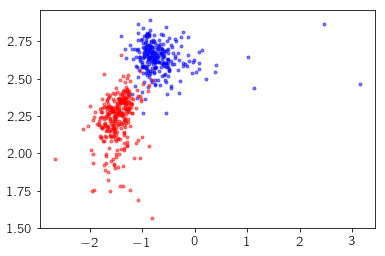

In [106]:
C1 = i-w2
# C2 = z-w2
C2 = logWimx


idx = np.where(pc0<-1.5)
C1_l = C1[idx]
C2_l = C2[idx]

idx = np.where(pc0>1.5)
C1_r = C1[idx]
C2_r = C2[idx]

plt.plot(C1_r, C2_r, 'b.', alpha=0.5)
plt.plot(C1_l, C2_l, 'r.', alpha=0.5)


plt.show()

In [407]:
import random 

#################################################################
def my_shuffle(array):
        random.seed(20)
        random.shuffle(array)
        return array
#################################################################

M0 = logWimx
MU = mu50
C0 = c21w
C1 = g-w2
C2 = r-w2
C3 = i-w2
C4 = z-w2
C5 = w1-w2
GR = g-r
RI = r-i

indices = np.arange(len(pgc))
indices = my_shuffle(indices)
MU = MU[indices]
M0 = M0[indices]
C0 = C0[indices]
C1 = C1[indices]
C2 = C2[indices]
C3 = C3[indices]
C4 = C4[indices]
C5 = C5[indices]
P0 = pc0[indices]
GR = GR[indices]
RI = RI[indices]

N = 350   # number of cross validation data points
MU_ = MU[:N]
M0_ = M0[:N]
C0_ = C0[:N]
C1_ = C1[:N]
C2_ = C2[:N]
C3_ = C3[:N]
C4_ = C4[:N]
C5_ = C5[:N]
P0_ = P0[:N]
GR_  = GR[:N]
RI_  = RI[:N]

MU = MU[N:]
M0 = M0[N:]
C0 = C0[N:]
C1 = C1[N:]
C2 = C2[N:]
C3 = C3[N:]
C4 = C4[N:]
C5 = C5[N:]
P0 = P0[N:]
GR = GR[N:]
RI = RI[N:]

################################
n = 5  # number of features

N = len(P0)
X = np.ones(shape = (n,N))
X1 = np.ones(shape = (n,N))
X2 = np.ones(shape = (n,N))
X[0] = GR; X[1] = C2; X[2] = RI
X1[0] = GR; X1[1] = C2; X1[2] = RI
X2[0] = GR; X2[1] = C2; X2[2] = RI
X[3] = M0; X1[3] = MU; X2[3] = C0
X[4] = MU; X1[4] = C0; X2[4] = M0


N = len(P0_)
x = np.ones(shape = (n,N))
x1 = np.ones(shape = (n,N))
x2 = np.ones(shape = (n,N))
x[0] = GR_; x[1] = C2_; x[2] = RI_
x1[0] = GR_; x1[1] = C2_; x1[2] = RI_
x2[0] = GR_; x2[1] = C2_; x2[2] = RI_
x[3] = M0_; x1[3] = MU_; x2[3] = C0_
x[4] = MU_; x1[4] = C0_; x2[4] = M0_

Xy = X.T; Xy1 = X1.T; Xy2 = X2.T; 
xy = x.T; xy1 = x1.T; xy2 = x2.T;
################################
n = 4  # number of features

N = len(P0)
X = np.ones(shape = (n,N))
X1 = np.ones(shape = (n,N))
X2 = np.ones(shape = (n,N))
X[0] = GR; X[1] = C2; X[2] = RI
X1[0] = GR; X1[1] = C2; X1[2] = RI
X2[0] = GR; X2[1] = C2; X2[2] = RI
X[3] = M0; X1[3] = MU; X2[3] = C0


N = len(P0_)
x = np.ones(shape = (n,N))
x1 = np.ones(shape = (n,N))
x2 = np.ones(shape = (n,N))
x[0] = GR_; x[1] = C2_; x[2] = RI_
x1[0] = GR_; x1[1] = C2_; x1[2] = RI_
x2[0] = GR_; x2[1] = C2_; x2[2] = RI_
x[3] = M0_; x1[3] = MU_; x2[3] = C0_

Xz = X.T; Xz1 = X1.T; Xz2 = X2.T; 
xz = x.T; xz1 = x1.T; xz2 = x2.T;
################################

y = P0
y_ = P0_

In [408]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

##################
regr = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=4, \
                             min_samples_leaf=3, bootstrap=True)
regr.fit(Xy, y)
yp  = regr.predict(Xy)
yp_ = regr.predict(xy)
print(regr.feature_importances_), np.std(y-yp), np.std(y_-yp_)
##################
regr1 = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=4, \
                             min_samples_leaf=3, bootstrap=True)
regr1.fit(Xy1, y)
yp1  = regr1.predict(Xy1)
yp1_ = regr1.predict(xy1)
print(regr1.feature_importances_), np.std(y-yp1), np.std(y_-yp1_)
##################
regr2 = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=4, \
                             min_samples_leaf=3, bootstrap=True)
regr2.fit(Xy2, y)
yp2  = regr2.predict(Xy2)
yp2_ = regr2.predict(xy2)
print(regr2.feature_importances_), np.std(y-yp2), np.std(y_-yp2_)
##################



[0.15101642 0.37008106 0.01310815 0.0876531  0.37814127] 0.2250633171065659 0.3505898057169722
[0.04174439 0.1350984  0.01320966 0.23996616 0.56998138] 0.2329060415349402 0.3553222489047295
[0.04814472 0.21445832 0.00808919 0.60631617 0.12299161] 0.22497924708465164 0.3568280851967567


In [409]:
##################
regr = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=3, \
                             min_samples_leaf=3, bootstrap=True)
regr.fit(Xz, y)
ypz  = regr.predict(Xz)
ypz_ = regr.predict(xz)
print(regr.feature_importances_), np.std(y-ypz), np.std(y_-ypz_)
##################
regr1 = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=3, \
                             min_samples_leaf=3, bootstrap=True)
regr1.fit(Xz1, y)
ypz1  = regr1.predict(Xz1)
ypz1_ = regr1.predict(xz1)
print(regr1.feature_importances_), np.std(y-ypz1), np.std(y_-ypz1_)
##################
regr2 = RandomForestRegressor(max_depth=500, n_estimators=1000, max_features=3, \
                             min_samples_leaf=3, bootstrap=True)
regr2.fit(Xz2, y)
ypz2  = regr2.predict(Xz2)
ypz2_ = regr2.predict(xz2)
print(regr2.feature_importances_), np.std(y-ypz2), np.std(y_-ypz2_)
##################


[0.30413234 0.57806567 0.02909694 0.08870506] 0.35208536859121886 0.5274542980334858
[0.17040342 0.40665983 0.03110019 0.39183655] 0.30289721656935675 0.4703380993324524
[0.07680978 0.29134853 0.01838306 0.61345863] 0.3139008061462473 0.4975105336598263


0.009389802203352282 0.1704298609100691
0.008198904187479983 0.25475766885874684


(-4, 4)

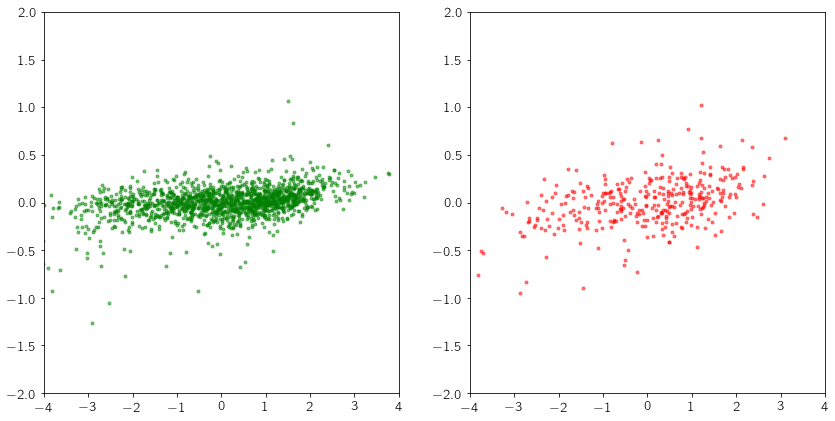

In [414]:
# yp0 = ((yp+yp1+yp2)+(ypz+ypz1+ypz2))/6.
# yp0_ = ((yp_+yp1_+yp2_)+(ypz_+ypz1_+ypz2_))/6.

# yp0 = np.c_[yp.ravel(),yp1.ravel(), yp2.ravel(), ypz.ravel(), ypz1.ravel(), ypz2.ravel()]
# yp0 = np.median(yp0,1)

# yp0_ = np.c_[yp_.ravel(),yp1_.ravel(), yp2_.ravel(), ypz_.ravel(), ypz1_.ravel(), ypz2_.ravel()]
# yp0_ = np.median(yp0_,1)


yp0 = np.c_[yp.ravel(),yp1.ravel(), yp2.ravel()]
yp0 = np.median(yp0,1)

yp0_ = np.c_[yp_.ravel(),yp1_.ravel(), yp2_.ravel()]
yp0_ = np.median(yp0_,1)


# yp0 = np.c_[ypz.ravel(), ypz1.ravel(), ypz2.ravel()]
# yp0 = np.median(yp0,1)

# yp0_ = np.c_[ypz_.ravel(), ypz1_.ravel(), ypz2_.ravel()]
# yp0_ = np.median(yp0_,1)


plt.figure(figsize=(14,7))
ax = plt.gcf().add_subplot(1,2,1)

print np.median(y-yp0), np.std(y-yp0)
plt.plot(y, y-yp0, 'g.', alpha=0.5)
plt.ylim([-2,2])
plt.xlim([-4,4])

ax = plt.gcf().add_subplot(1,2,2)
print np.median(y_-yp0_), np.std(y_-yp0_)
plt.plot(y_, y_-yp0_, 'r.', alpha=0.5)
plt.ylim([-2,2])
plt.xlim([-4,4])

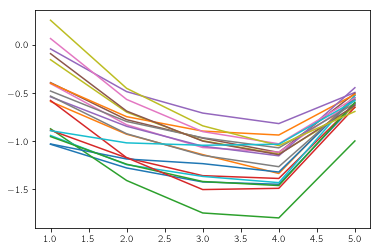

In [87]:
X0 = [1,2,3,4,5]
for i in range(20):
    plt.plot(X0, [C1[i], C2[i], C3[i], C4[i], C5[i]], '-')


# Using George Package

In [62]:
import george
from george import kernels

################################################################# 
def nll_fn2(X_train, Y_train):
    
    def step(theta):
        
        l1 = np.exp(theta[0])
        l2 = np.exp(theta[1])
        l3 = np.exp(theta[2])
        l4 = np.exp(theta[3])
        sigma = np.exp(theta[4])
        yerr = np.abs(0.2*Y_train)
        
        #kernel = sigma * kernels.Matern52Kernel([l1,l2,l3,l4], ndim=4, axes=[0,1,2,3])
        kernel = sigma * kernels.ExpSquaredKernel([l1,l2,l3,l4], ndim=4, axes=[0,1,2,3])

        gp = george.GP(kernel)
        gp.compute(X_train, yerr)

        return -gp.lnlikelihood(Y_train)
    return step
################################################################# 

### Maximum Likelihood
result = minimize(nll_fn2(X, y), [0, 0, 0, 0, 1], 
               bounds=((None, None), (None, None), (None, None), (None, None), (None, None)),
               method='L-BFGS-B')
print result

      fun: 2104.568185775214
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.09494702e-05, -1.36424205e-04, -1.36424205e-04, -1.36424205e-04,
        4.09272616e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 180
      nit: 18
   status: 0
  success: True
        x: array([-9.40876717, -6.6061314 , -5.29084987, -4.32756596,  0.59961012])


0.061677797338620784


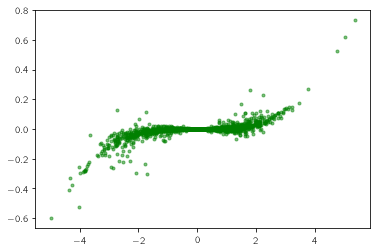

In [63]:
theta =  result.x
        
l1 = np.exp(theta[0])
l2 = np.exp(theta[1])
l3 = np.exp(theta[2])
l4 = np.exp(theta[3])
sigma = np.exp(theta[4])
yerr = np.abs(0.1*y)
kernel = sigma * kernels.Matern52Kernel([l1,l2,l3,l4], ndim=4, axes=[0,1,2,3])
gp = george.GP(kernel)
gp.compute(X, yerr)


y_pred, sigma = gp.predict(y, X, return_var=True)
print(np.sqrt(np.mean((P0-y_pred)**2)))
plt.plot(P0, P0-y_pred, 'g.', alpha=0.5)

0.9147254341134436
0.914409156338934


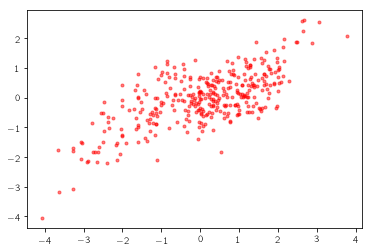

In [66]:
y_pred, sigma = gp.predict(y, x, return_var=True)
print(np.sqrt(np.mean((P0_-y_pred)**2)))
print np.std(P0_-y_pred)
plt.plot(P0_, P0_-y_pred, 'r.', alpha=0.5)